# 텐서플로우를 이용한 K-means

### 1. 필요한 모듈들을 불러옵니다.

* pandas는 excel이나 csv 등 데이터 처리를 위한 라이브러리입니다.
* seaborn은 우아한 시각화를 도와주는 라이브러리입니다.

In [160]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### 2. 데이터들을 정의해 줍니다. 

벡터의 갯수, 클러스터의 갯수, 학습 횟수를 정의해 줍니다. 

In [161]:
num_dots = 1000
num_clusters = 3
num_epochs = 100

분류의 대상이 될 1,000개의 점들을 정의해 줍니다. 크게 3개 정도의 덩어리로 구성되도록 설정해 주었습니다. 
* (0.0, 2.0)
* (2.0, -1.0)
* (-1.0, -2.0)

In [162]:
dots = []
for i in xrange(num_dots):
    if np.random.random() > 0.66:
        dots.append([np.random.normal(0.0, 1.0), np.random.normal(2.0, 0.5)])
    elif np.random.random() > 0.33:
        dots.append([np.random.normal(2.0, 1.3), np.random.normal(-1.0, 0.6)])
    else:
        dots.append([np.random.normal(-1.0, 0.8), np.random.normal(-2.0, 1.2)])

pandas를 이용해 좌표를 데이터프레임 형태로 저장합니다.

In [163]:
df = pd.DataFrame({"x": [v[0] for v in dots], 
                   "y": [v[1] for v in dots]})

df.head() 명령어를 통해 데이터 일부를 살펴 봅니다. 

In [164]:
df.head(10)

,x,y
0,1.108665,1.372450
1,-0.274423,-1.622566
2,0.685857,-0.519320
3,3.149376,-0.059453
4,0.868784,1.809896
5,1.134742,-1.128359
6,-1.791197,-1.382560
7,-1.322832,-4.437527
8,3.683241,0.226663
9,2.074652,2.558436


Seaborn을 이용해 데이터를 시각화해 봅니다.

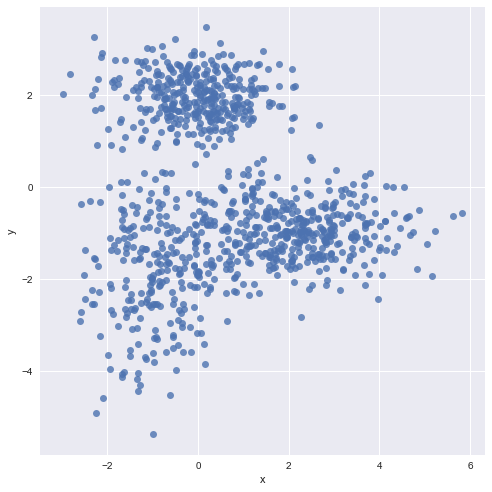

In [175]:
sns.lmplot("x", "y", data=df, fit_reg=False, size=7)
plt.show()

### 3. 그래프 생성하기

dots를 vector라는 텐서플로우 상수에 저장해 줍니다. 
* get_shape()을 이용해 (1000,2)의 shape을 가지는 것을 확인합니다. 

In [176]:
vectors = tf.constant(dots)
vectors.get_shape()

TensorShape([Dimension(1000), Dimension(2)])

vectors를 랜덤하게 섞어 준 다음에 3개를 추출하여 centroids라는 변수에 저장합니다. 

In [177]:
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], [num_clusters,-1]))
centroids.get_shape()

TensorShape([Dimension(3), Dimension(2)])

vectors는 (1000,2), centroids는 (3,2)의 차원을 가지기 때문에 2개간에 차를 구하는 연산이 불가능합니다. 
* 이럴 때 할 수 있는 것이 차원의 확장입니다. 
* vectors는 첫번째 차원을 확장해 줍니다 --> (1,1000,2)
* centroids는 두번째 차원을 확장해 줍니다. --> (3,1,2)

In [178]:
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

print expanded_vectors.get_shape()
print expanded_centroids.get_shape()

(1, 1000, 2)
(3, 1, 2)


(1000,2)의 expanded_vectos와 (1,2)의 expanded_centroids 간에는 브로드캐스팅이 자동으로 발생하게 됩니다. 
* 따라서 expanded_vectors - expanded_centroids 를 구하여 
* L2 distance (Euclidean distance) 를 구할 수 있게 됩니다.
* 거리가 가장 작은 순으로 인자들이 assignments에 저장됩니다.

In [179]:
distances = tf.reduce_sum(
  tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)
assignments.get_shape()

TensorShape([Dimension(1000)])

이제 각 클러스터에 속하는 점들을 모은 다음에, 이 점들을 평균함으로써 새로운 중심점을 계산해 냅니다.

In [180]:
means = tf.concat([
  tf.reduce_mean(tf.gather(vectors, tf.reshape(tf.where(tf.equal(assignments, c)),[1,-1])),reduction_indices=[1])
  for c in xrange(num_clusters)], 0)

이를 통해 중심점을 업데이트합니다.

In [181]:
centroids_updated = tf.assign(centroids, means)

### 4. 그래프 실행하기

In [182]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in xrange(num_epochs):
    _, centroid_values, assignment_values = sess.run([centroids_updated,
                                                      centroids,
                                                      assignments])
  print "중심점"
  print centroid_values

중심점
[[ 2.40067291 -0.91806924]
 [-0.72542769 -1.83680773]
 [-0.08374371  1.93120611]]


### 5. 시각화하여 보여주기

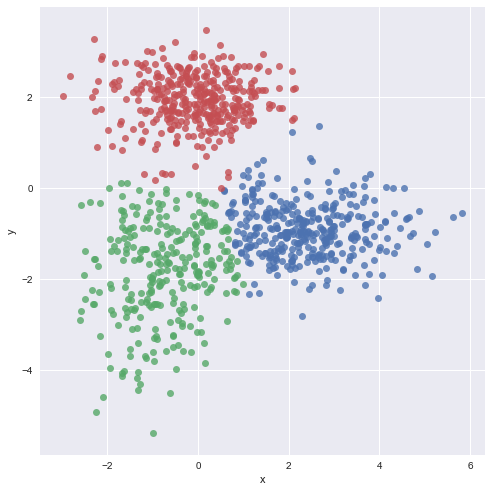

In [183]:
data = {"x": [], "y": [], "cluster": []}
for i in xrange(len(assignment_values)):
  data["x"].append(dots[i][0])
  data["y"].append(dots[i][1])
  data["cluster"].append(assignment_values[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, 
           fit_reg=False, size=7, 
           hue="cluster", legend=False)
plt.show()